# Data Engineer Coding Challenge 

<h4>Juan Sebastian Garcia Rodriguez</h4>


<a href="https://www.linkedin.com/in/jsebastiangarcia29/">Linkedin Profile</a>

## Step1: Procesamiento de datos

Para generar la matriz para el analisis puede correr las siguientes celdas

In [1]:

!python pipeline.py


Para el procesamiento de datos se utilizo un procesamiento por capas, el cual consiste en procesar los datos en crudo y generar una copia pre processada del input en JSON. Luego, procedemos a normalizar los datos y cambiar tipos de datos para tener calidad de datos en una capa silver/curated. Finalmente, para generar datasets para ML or analisis, se genera una matriz basada en el dataset prints, esta matriz es generada por un grupo de funciones que procesa la informacion de cada usuario.

Si pudiera mejorar este proceso:
- Primero, para la capa silver, implementaria reglas de calidad de datos para poder proteger la calidad de datos que ingresa al model.
- Para la capa analitica hacer optimizaciones sobre el codigo pero lo mas importante es mejorar la forma como se produce la serie de tiempo de cada usuario, debido a que la implementacion utiliza group bys, lo cual puede ser muy costoso en ambientes distribuidos (ya que requiere shuffling).
- Monitoreo de la completitud de lso datos, estadisticas descriptivas y variables missing.
- Evolucion del schema, puede que en algun momento el proceso obtenga nuevos datos que generen varaibles no esperadas resultado de una nueva categoria en value props, puede ser imporante generar facilidades para que eso no rompa el pipeline.

Para entregar y servir la data puede ser buena idea contar con un Feature store que alimente este proceso y remueva una buena parte del procesamiento de datos para que siemplemente el codigo procese en lo mas minimo cuando el servicio se de al usuario. Igualmente, para evitar errores silenciosos de tipso de datos o nombres de columnas, se podria utilizar un gestionador del ciclo de vida de los modelos como MLFlow, que cuando se sirva el modelo tenga schema enforcement para que cada columna y tipo  de dato sea verificado antes de predecir.

## Step 2: Recomendaciones

En el contexto de MercadoPago, se quiere desarrollar un modelo de Machine Learning para predecir el orden de un conjunto de Propuestas de Valor (aka, Value Props) en el carrusel de la app llamado “Descubrí Más”.

Teniendo en cuenta la informacion que contiene la semana, se puede decir que el modelo trabaja con tres grupos de variables. La mas completa y de mayor variabilidad son los views, luego de los pagos hechos. Igualmente se observan que cuando se analiza la semana estas dos variables tienen un comportamiento predecible, lo cual puede ser una fuente de monitoreo si el modelo las utiliza. Ya que el modelo puede ajustarse a este comportamiento y en alguna semana donde no exista este comportamiento pueda que haya algun drift. El grupo de variable menos completo y con mayor ruido son los clicks, de los cuales podemos decir que habria que mirar si tienen algun poder predictivo o uso util.

Si el modelo usa todas las variables (que no creo) es importante monitorear la completitud de las variables, distribucion de las variables, la distribucion de las variables dada cada posicion (para detectar concept drift), como tambien el comportamiento por dia de esos indicadores.

Por ultimo, puede ser tambien para generar early warning el monitoreo de las predicciones y hace run forcasting del performance del modelo a futuras semanas.

### "Detailed"

- Se observa que esa representatividad se mantiene entre todas las posiciones lo cual creo que no vuelve muy predictiva la variable
- Igualmente el dataset tiene tres grupos de varaibles para informar, pagos, clicks y vistas, y cada grupo parece tener una completitud homogenea (32%, 71%, 10%). Incluiria de cierta forma en un modelo las variables por cada categoria. Podria ser usado modelos que puedan nativamente utilizar el valor Nulo como informacion adicional. Lo anterior se repite igualmente para analizar la variabilidad donde por cada categoria se puede ver que la variabilidad es muy homogenea. Una estategia puede ser abordar la seleccion de varialbes por cada categoria utilizando solo una varaible de cada categoria, ya que depronto pueden incluir la misma informacion.
- Finalmente, analizando el target (el orden or al varaible *position*) frente a las metricas extraidas de las fuentes de informacion hay tres "patrones":
  - Como puede esperarse los consumidores generan menos interaciones, menos pagos y ven menos los value props que se le presentan en las ultimas posiciones.
  - Los consumidores parecieran generar el mayor numero de pagos el segundo dia (25/Sabado) y apartir de ese dia hay una caida con tendencia decreciente y monotonica en la cantidad de pagos. Comportamiento que es estable a traves de las categorias de la varaible target.
  - Los usuarios Igualmente tienen dos dias particulares para incrementar sus vistas a lso values props, que son lso dias 29 y 25, esta linea de tiempo tiene mas varaibilidad y no es decreciente por lo que tiene dos picos durante la semana. 
  - Cuando se analizan los Clicks es posible ver una varaibilidad mucho mayor y no es tan facil hacer alguna conclusion, pero podria ser muy util ver cuales de esas variables de clicks nos dan mejor poder predictivo.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_theme(style="whitegrid")

In [4]:
# leer df analysis
df_analysis_full = pd.read_parquet('data/gold/joined_table_gold.parquet')

df_analysis = pd.read_parquet('data/gold/analysis_table_processed.parquet')
df_analysis['count_me'] = 1


click_user_value_prop
False    0.899791
True     0.100209
Name: count, dtype: float64


/tmp/ipykernel_55529/3224527763.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_analysis['click_user_value_prop'] = df_analysis['click_user_value_prop'].fillna(False)


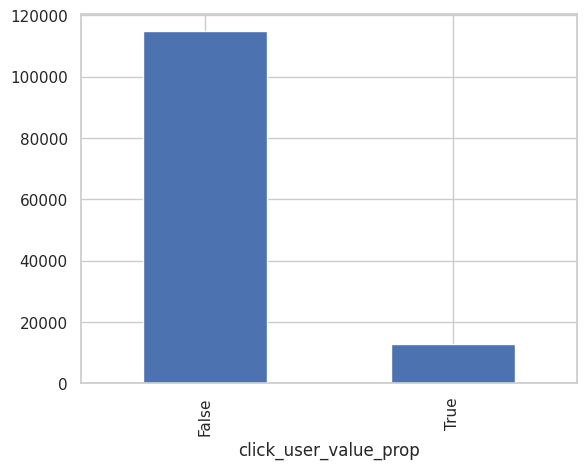

In [5]:
# Analizar el target
df_analysis['click_user_value_prop'] = df_analysis['click_user_value_prop'].fillna(False)
df_analysis['click_user_value_prop'].value_counts().plot(kind='bar')

print(df_analysis['click_user_value_prop'].value_counts()/len(df_analysis['click_user_value_prop']))

In [6]:
report_cross = df_analysis.groupby(['position', 'click_user_value_prop']).agg({'count_me': ['sum']}).unstack(1).reset_index()
report_cross.columns = ['position', 'click_user_value_prop_true', 'click_user_value_prop_false']
report_cross[['click_user_value_prop_true','click_user_value_prop_false']].apply(lambda row: row/row.sum(), axis=1)


,click_user_value_prop_true,click_user_value_prop_false
0,0.900086,0.099914
1,0.898582,0.101418
2,0.903373,0.096627
3,0.895120,0.104880


## Univariado

In [7]:
df_analysis.columns

Index(['day', 'user_id', 'position', 'value_prop_prints', 'value_prop_taps',
       'click_user_value_prop', 'pay_date', 'payment_sum_credits_consumer',
       'payment_sum_link_cobro', 'payment_sum_prepaid',
       'payment_sum_send_money', 'payment_qty_credits_consumer',
       'payment_qty_link_cobro', 'payment_qty_prepaid',
       'payment_qty_send_money', 'payment_sum_cellphone_recharge',
       'payment_sum_point', 'payment_sum_transport',
       'payment_qty_cellphone_recharge', 'payment_qty_point',
       'payment_qty_transport', 'value_prop_user_views_transport',
       'value_prop_user_views_point', 'value_prop_user_views_prepaid',
       'value_prop_user_views_cellphone_recharge',
       'value_prop_user_views_credits_consumer',
       'value_prop_user_views_link_cobro', 'value_prop_user_views_send_money',
       'value_prop_user_clicks_prepaid', 'value_prop_user_clicks_send_money',
       'value_prop_user_clicks_transport',
       'value_prop_user_clicks_cellphone_recharge'

In [8]:
univ_cols = ['click_user_value_prop', 'payment_sum_credits_consumer',
       'payment_sum_link_cobro', 'payment_sum_prepaid',
       'payment_sum_send_money', 'payment_qty_credits_consumer',
       'payment_qty_link_cobro', 'payment_qty_prepaid',
       'payment_qty_send_money', 'payment_sum_cellphone_recharge',
       'payment_sum_point', 'payment_sum_transport',
       'payment_qty_cellphone_recharge', 'payment_qty_point',
       'payment_qty_transport', 'value_prop_user_views_transport',
       'value_prop_user_views_point', 'value_prop_user_views_prepaid',
       'value_prop_user_views_cellphone_recharge',
       'value_prop_user_views_credits_consumer',
       'value_prop_user_views_link_cobro', 'value_prop_user_views_send_money',
       'value_prop_user_clicks_prepaid', 'value_prop_user_clicks_send_money',
       'value_prop_user_clicks_transport',
       'value_prop_user_clicks_cellphone_recharge',
       'value_prop_user_clicks_link_cobro', 'value_prop_user_clicks_point',
       'value_prop_user_clicks_credits_consumer']

In [9]:
## veamos las variables mas informativas
total_n = len(df_analysis)
report_ = df_analysis[univ_cols].describe().T
report_['completeness'] = report_['count']/total_n
report_.sort_values(by=['std'], ascending=False)

,count,mean,std,min,25%,50%,75%,max,completeness
payment_sum_credits_consumer,41532.0,55.925733,63.381114,0.0,2.060,35.39,88.4100,481.90,0.325603
payment_sum_link_cobro,41880.0,56.063330,62.941542,0.0,3.080,35.42,89.5025,501.81,0.328332
payment_sum_cellphone_recharge,41484.0,55.550648,62.757048,0.0,2.140,34.21,89.5100,494.50,0.325227
payment_sum_transport,41529.0,55.223044,62.374408,0.0,2.450,34.21,88.3200,540.94,0.325580
payment_sum_prepaid,41384.0,55.464893,61.933440,0.0,2.380,34.66,89.4525,430.58,0.324443
payment_sum_point,41755.0,55.266914,61.842586,0.0,1.995,35.24,88.8700,446.60,0.327352
payment_sum_send_money,41793.0,55.200815,61.842162,0.0,2.250,35.19,88.2700,403.31,0.327649
payment_qty_credits_consumer,41532.0,1.107893,0.846301,0.0,1.000,1.00,2.0000,6.00,0.325603
payment_qty_point,41755.0,1.110166,0.843579,0.0,1.000,1.00,2.0000,6.00,0.327352
payment_qty_transport,41529.0,1.114474,0.841055,0.0,1.000,1.00,2.0000,7.00,0.325580


In [10]:
# las variables mas completas
report_.sort_values(by=['completeness'], ascending=False).head().index

Index(['value_prop_user_views_credits_consumer', 'value_prop_user_views_point',
       'value_prop_user_views_transport',
       'value_prop_user_views_cellphone_recharge',
       'value_prop_user_views_prepaid'],
      dtype='object')

In [11]:
# las variables menos completas
report_.loc[report_['completeness']<=0.15].index

Index(['value_prop_user_clicks_prepaid', 'value_prop_user_clicks_send_money',
       'value_prop_user_clicks_transport',
       'value_prop_user_clicks_cellphone_recharge',
       'value_prop_user_clicks_link_cobro', 'value_prop_user_clicks_point',
       'value_prop_user_clicks_credits_consumer'],
      dtype='object')

In [62]:
df_analysis = df_analysis.set_index('day')

In [12]:
df_analysis

,day,user_id,position,value_prop_prints,value_prop_taps,click_user_value_prop,pay_date,payment_sum_credits_consumer,payment_sum_link_cobro,payment_sum_prepaid,...,value_prop_user_views_link_cobro,value_prop_user_views_send_money,value_prop_user_clicks_prepaid,value_prop_user_clicks_send_money,value_prop_user_clicks_transport,value_prop_user_clicks_cellphone_recharge,value_prop_user_clicks_link_cobro,value_prop_user_clicks_point,value_prop_user_clicks_credits_consumer,count_me
381063,2020-11-23,69000,0,credits_consumer,None,False,2020-11-23,0.00,0.00,143.82,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
381064,2020-11-23,69000,1,link_cobro,None,False,2020-11-23,0.00,0.00,143.82,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
381065,2020-11-23,69000,2,transport,None,False,2020-11-23,0.00,0.00,143.82,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
381066,2020-11-23,69000,3,prepaid,None,False,2020-11-23,0.00,0.00,143.82,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
381067,2020-11-23,66521,0,prepaid,None,False,2020-11-23,8.53,0.00,157.87,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508612,2020-11-30,50807,0,send_money,None,False,NaT,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
508613,2020-11-30,50807,1,prepaid,None,False,NaT,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
508614,2020-11-30,50807,2,credits_consumer,None,False,NaT,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
508615,2020-11-30,1487,0,point,None,False,2020-11-30,196.63,91.42,33.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [17]:
def get_descriptive_stats(report_):
    total_n = len(report_)
    report_ = report_[univ_cols].describe().T
    report_['completeness'] = report_['count']/total_n    
    return report_

In [19]:
report_daily = df_analysis.groupby('day').apply(lambda x : get_descriptive_stats(x[univ_cols]))

/tmp/ipykernel_55529/537241340.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  report_daily = df_analysis.groupby('day').apply(lambda x : get_descriptive_stats(x[univ_cols]))


In [26]:
report_daily.mean()

count           5899.450893
mean              14.356073
std               16.076868
min                0.000000
25%                0.746105
50%                9.140268
75%               22.998382
max              104.745179
completeness       0.369841
dtype: float64

<Axes: xlabel='day,None'>

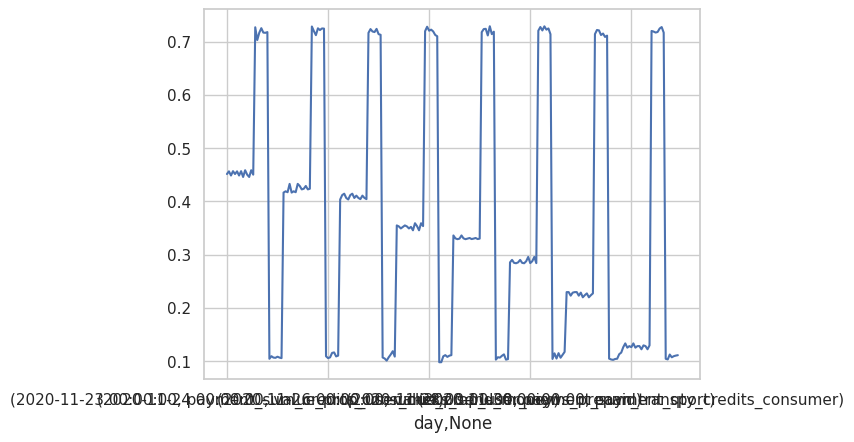

In [22]:
report_daily['completeness'].plot()

In [40]:
df_analysis[cols_analysis_payment]

,payment_sum_link_cobro,payment_sum_transport,payment_sum_prepaid,payment_sum_credits_consumer
381063,0.00,136.73,143.82,0.00
381064,0.00,136.73,143.82,0.00
381065,0.00,136.73,143.82,0.00
381066,0.00,136.73,143.82,0.00
381067,0.00,194.12,157.87,8.53
...,...,...,...,...
508612,NaN,NaN,NaN,NaN
508613,NaN,NaN,NaN,NaN
508614,NaN,NaN,NaN,NaN
508615,91.42,NaN,33.28,196.63


payment_sum_link_cobro          941503.88
payment_sum_transport           918935.14
payment_sum_prepaid             918656.68
payment_sum_credits_consumer    929922.86
payment_sum_send_money          924914.94
dtype: float64
payment_sum_link_cobro          701022.69
payment_sum_transport           688671.01
payment_sum_prepaid             688628.42
payment_sum_credits_consumer    695416.25
payment_sum_send_money          693174.25
dtype: float64
payment_sum_link_cobro          463300.07
payment_sum_transport           453272.63
payment_sum_prepaid             457910.65
payment_sum_credits_consumer    460552.12
payment_sum_send_money          457117.32
dtype: float64
payment_sum_link_cobro          242105.64
payment_sum_transport           232479.03
payment_sum_prepaid             230163.37
payment_sum_credits_consumer    236816.31
payment_sum_send_money          231801.15
dtype: float64


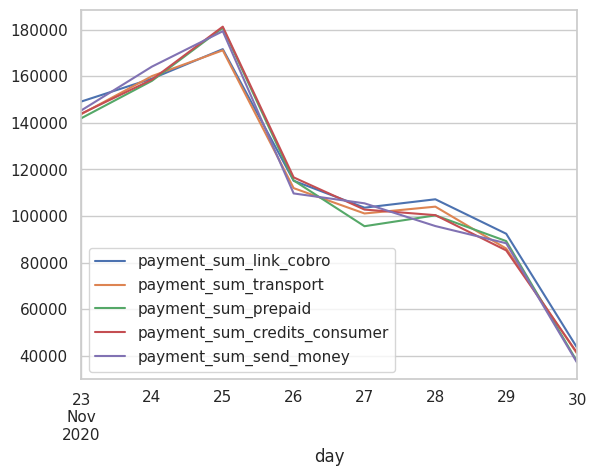

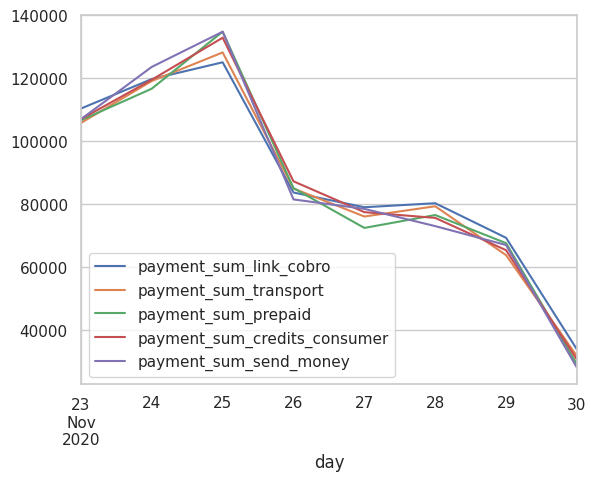

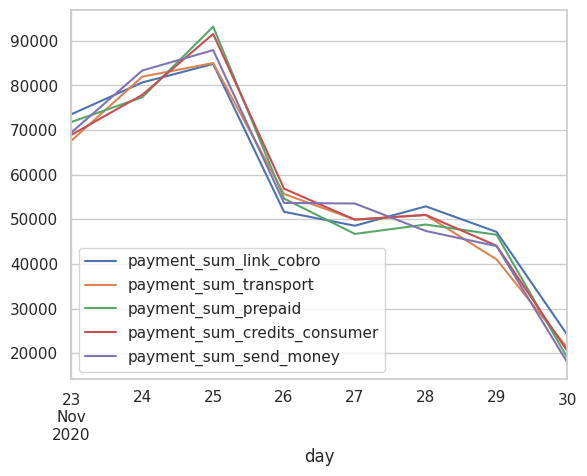

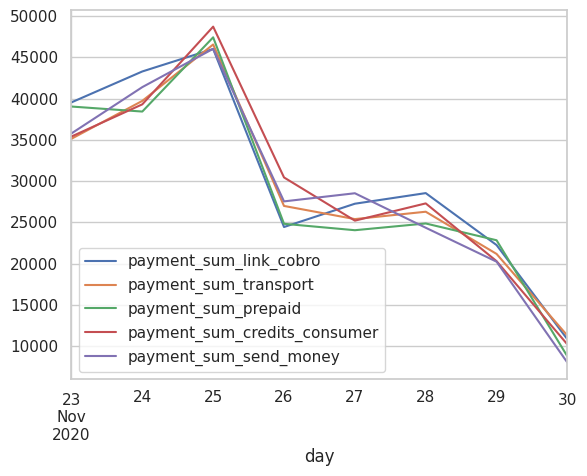

In [42]:
for pos_id in df_analysis['position'].unique():
    cols_analysis_payment = ['payment_sum_link_cobro',
                                'payment_sum_transport',
                                'payment_sum_prepaid',
                                'payment_sum_credits_consumer',
                                'payment_sum_send_money']
    df_current = df_analysis.loc[df_analysis['position']==pos_id]
    print(df_current[cols_analysis_payment].sum())
    df_current.groupby(['day'])[cols_analysis_payment].sum().plot()

value_prop_user_views_cellphone_recharge    26457.0
value_prop_user_views_credits_consumer      26392.0
value_prop_user_views_point                 26443.0
value_prop_user_views_link_cobro            26239.0
value_prop_user_views_transport             26230.0
value_prop_user_views_prepaid               26143.0
value_prop_user_views_send_money            25836.0
dtype: float64
value_prop_user_views_cellphone_recharge    19895.0
value_prop_user_views_credits_consumer      19863.0
value_prop_user_views_point                 19971.0
value_prop_user_views_link_cobro            19693.0
value_prop_user_views_transport             19646.0
value_prop_user_views_prepaid               19705.0
value_prop_user_views_send_money            19298.0
dtype: float64
value_prop_user_views_cellphone_recharge    13281.0
value_prop_user_views_credits_consumer      13202.0
value_prop_user_views_point                 13303.0
value_prop_user_views_link_cobro            12986.0
value_prop_user_views_transport   

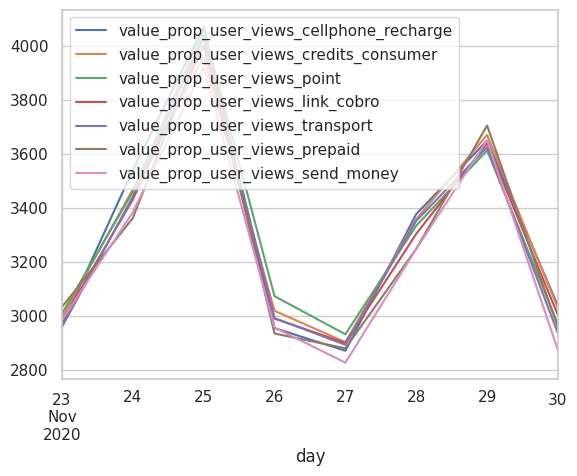

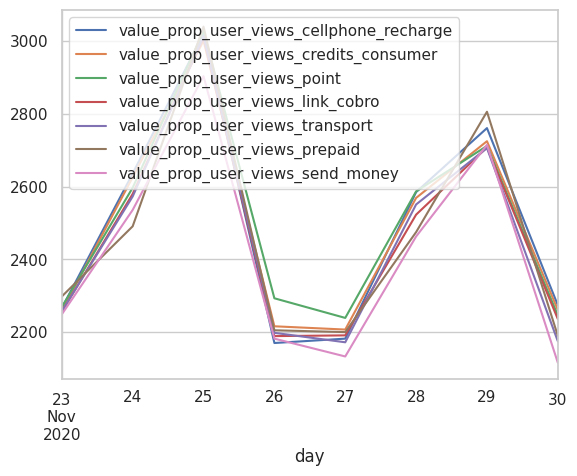

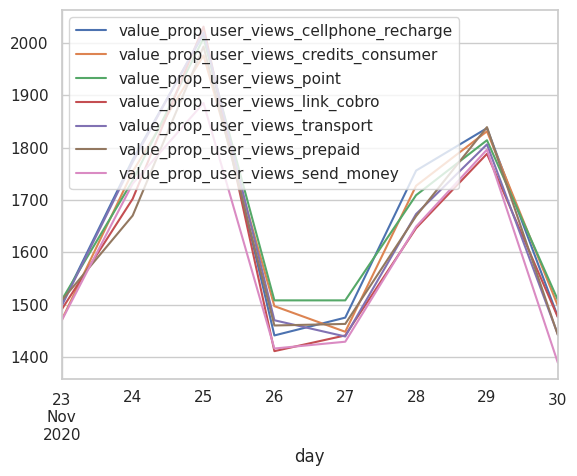

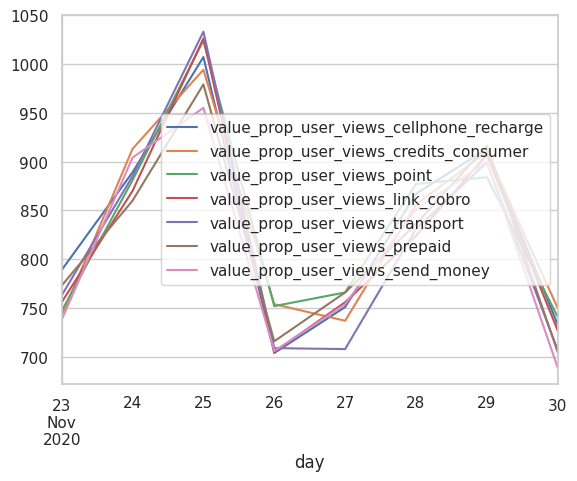

In [43]:
for pos_id in df_analysis['position'].unique():
    cols_analysis_payment = ['value_prop_user_views_cellphone_recharge',
                            'value_prop_user_views_credits_consumer',
                            'value_prop_user_views_point',
                            'value_prop_user_views_link_cobro',
                            'value_prop_user_views_transport','value_prop_user_views_prepaid', 'value_prop_user_views_send_money', ]
    df_current = df_analysis.loc[df_analysis['position']==pos_id]
    print(df_current[cols_analysis_payment].sum())
    df_current.groupby(['day'])[cols_analysis_payment].sum().plot()

value_prop_user_clicks_cellphone_recharge    2619.0
value_prop_user_clicks_point                 2695.0
value_prop_user_clicks_link_cobro            2740.0
value_prop_user_clicks_credits_consumer      2671.0
value_prop_user_clicks_prepaid               2553.0
value_prop_user_clicks_send_money            2565.0
value_prop_user_clicks_transport             2628.0
dtype: float64
value_prop_user_clicks_cellphone_recharge    1986.0
value_prop_user_clicks_point                 2067.0
value_prop_user_clicks_link_cobro            2091.0
value_prop_user_clicks_credits_consumer      1997.0
value_prop_user_clicks_prepaid               1900.0
value_prop_user_clicks_send_money            1892.0
value_prop_user_clicks_transport             1927.0
dtype: float64
value_prop_user_clicks_cellphone_recharge    1336.0
value_prop_user_clicks_point                 1369.0
value_prop_user_clicks_link_cobro            1356.0
value_prop_user_clicks_credits_consumer      1336.0
value_prop_user_clicks_prepaid    

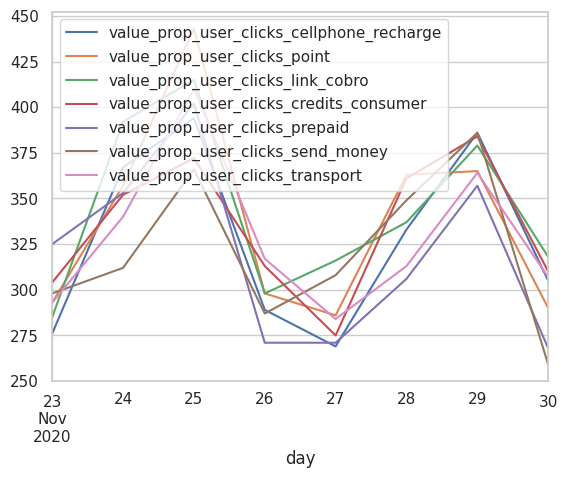

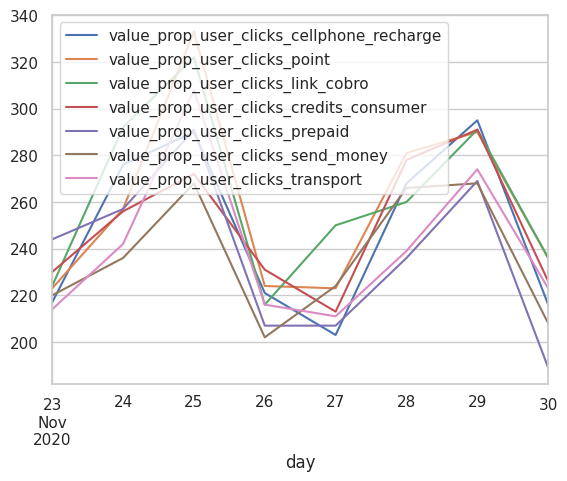

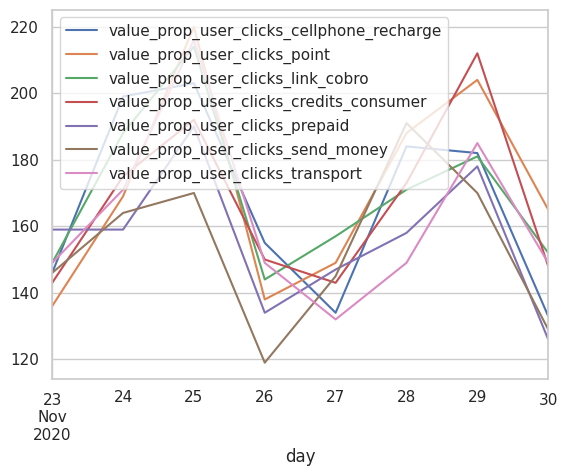

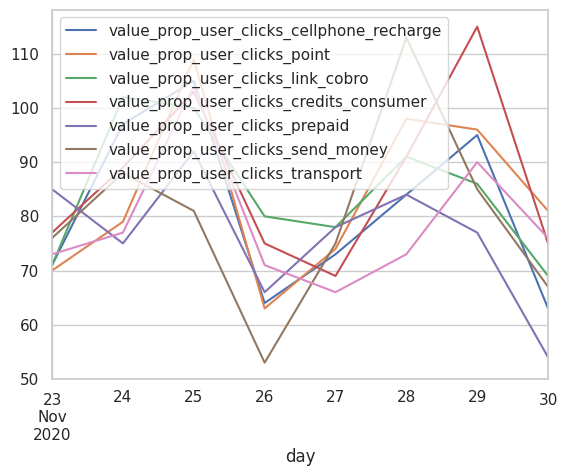

In [44]:
for pos_id in df_analysis['position'].unique():
    cols_analysis_payment = ['value_prop_user_clicks_cellphone_recharge', 'value_prop_user_clicks_point', 'value_prop_user_clicks_link_cobro', 'value_prop_user_clicks_credits_consumer', 'value_prop_user_clicks_prepaid', 'value_prop_user_clicks_send_money', 'value_prop_user_clicks_transport', ]
    df_current = df_analysis.loc[df_analysis['position']==pos_id]
    print(df_current[cols_analysis_payment].sum())
    df_current.groupby(['day'])[cols_analysis_payment].sum().plot()

In [ ]:
df_analysis.groupby('day')[['payment_sum_link_cobro',
                            'payment_sum_transport',
                            'payment_sum_prepaid',
                            'payment_sum_credits_consumer']].sum().plot()